In [1]:
import pandas as pd

# 加载数据集
data = pd.read_csv("Groceries_dataset.csv")

# 创建唯一事务ID
data['Transaction'] = data['Member_number'].astype(str) + "_" + data['Date']

# 将数据转换为事务-商品矩阵
transaction_data = pd.crosstab(data['Transaction'], data['itemDescription'])
transaction_data = transaction_data.map(lambda x: x > 0)  # 转换为bool类型

In [2]:
print(transaction_data.shape)

(14963, 167)


In [3]:
# 计算平均每个事务中的商品数量 T
average_items_per_transaction = transaction_data.sum(axis=1).mean()
print(f"Average number of items per transaction T: {average_items_per_transaction}")

Average number of items per transaction T: 2.539998663369645


In [4]:
# 生成不同事务数量的数据集
dataset_A = transaction_data.sample(n=2000)
dataset_B = transaction_data.sample(n=4000)
dataset_C = transaction_data.sample(n=6000)
dataset_D = transaction_data.sample(n=8000)

In [5]:
import random

# 固定事务数量为1000条
fixed_transactions = transaction_data.sample(n=4000)

# 随机选择不同数量的商品作为唯一项
unique_item_50 = random.sample(list(transaction_data.columns), 50)
unique_item_100 = random.sample(list(transaction_data.columns), 100)
unique_item_150 = random.sample(list(transaction_data.columns), 150)

# 生成不同唯一项数量的数据集
dataset_E = fixed_transactions[unique_item_50]
dataset_F = fixed_transactions[unique_item_100]
dataset_G = fixed_transactions[unique_item_150]

In [6]:
from mlxtend.frequent_patterns import apriori, association_rules
import time

# 定义函数以便在每个数据集上运行并记录时间
def run_apriori(data, min_support=0.01, min_confidence=0.5):
    # 记录生成频繁项集的时间
    start_time = time.time()
    frequent_itemsets = apriori(data, min_support=min_support, use_colnames=True)
    itemset_time = time.time() - start_time

    # 记录生成规则的时间
    start_time = time.time()
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    rules_time = time.time() - start_time
    
    return itemset_time, rules_time

In [7]:
import time
from itertools import combinations

def simulate_bruteforce_small(transaction_data, sample_size=5, min_support=0.01, min_confidence=0.5):
    """
    使用小规模数据集模拟暴力求解，并返回关键统计结果。
    """
    small_data = transaction_data.sample(n=sample_size)
    small_data = small_data.loc[:, small_data.any(axis=0)]
    M = small_data.shape[1]
    N = small_data.shape[0]
    T = small_data.sum(axis=1).mean()

    # 生成频繁项集的时间
    start_time = time.time()
    frequent_itemsets = {}
    for k in range(1, M + 1):
        for itemset in combinations(small_data.columns, k):
            support_count = small_data[list(itemset)].all(axis=1).sum()
            support = support_count / N
            if support >= min_support:
                frequent_itemsets[itemset] = support
    itemset_generation_time = time.time() - start_time

    return {
        'N': N,
        'M': M,
        'T': T,
        'itemset_time': itemset_generation_time
    }

def estimate_large_dataset_time(transaction_data, small_results):
    
    
    N_small = small_results['N']
    M_small = small_results['M']
    T_small = small_results['T']
    itemset_time_small = small_results['itemset_time']
    
    N_large = transaction_data.shape[0]
    M_large = transaction_data.shape[1]
    T_large = transaction_data.sum(axis=1).mean()

    # 估算频繁项集生成时间，考虑N、M和T的影响
    estimated_time = itemset_time_small * (N_large / N_small) * (2 ** (M_large - M_small)) * (T_large / T_small)

    return {
        'estimated_time': estimated_time
    }


small_results = simulate_bruteforce_small(transaction_data)
results = {}
for dataset_name, dataset in zip(["A", "B", "C", "D", "E", "F", "G"], 
                                 [dataset_A, dataset_B, dataset_C, dataset_D, dataset_E, dataset_F, dataset_G]):
    
    itemset_time, rules_time = run_apriori(dataset)
    results[dataset_name] = {"apriori_time": itemset_time + rules_time}
    
    
    estimate = estimate_large_dataset_time(dataset,small_results)
    estimated_time = estimate['estimated_time']
    results[dataset_name].update({"estimated_time": estimated_time})

    print(f"{dataset_name} - measured time using apriori: {itemset_time + rules_time}s")
    print(f"  - estimated time using brute-force approach: {estimated_time}s")

A - measured time using apriori: 0.007978439331054688s
  - estimated time using brute-force approach: 2.697273527535088e+49s
B - measured time using apriori: 0.015665531158447266s
  - estimated time using brute-force approach: 5.380270171078127e+49s
C - measured time using apriori: 0.022406816482543945s
  - estimated time using brute-force approach: 8.133064914137854e+49s
D - measured time using apriori: 0.02934861183166504s
  - estimated time using brute-force approach: 1.0715594596255357e+50s
E - measured time using apriori: 0.003081083297729492s
  - estimated time using brute-force approach: 90540407439360.02s
F - measured time using apriori: 0.00652623176574707s
  - estimated time using brute-force approach: 2.201461851093931e+29s
G - measured time using apriori: 0.012634992599487305s
  - estimated time using brute-force approach: 3.611435091847517e+44s


D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


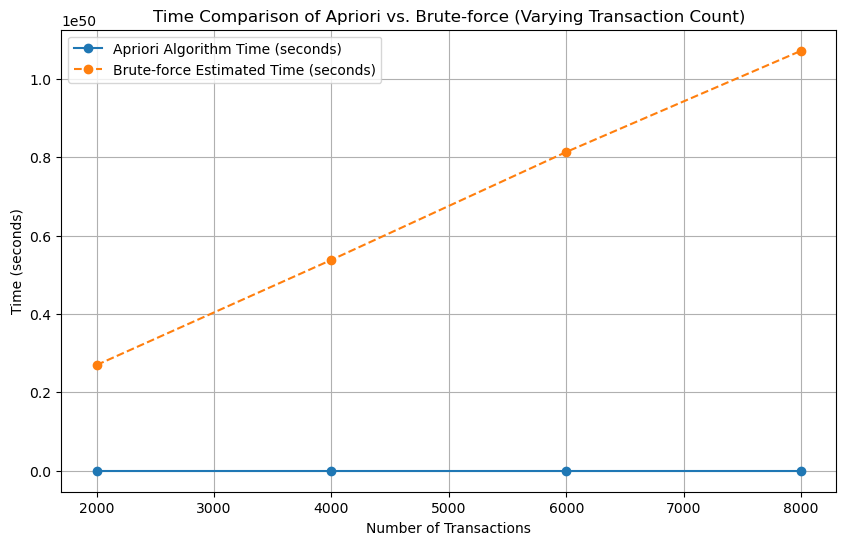

In [8]:
import matplotlib.pyplot as plt

# 提取事务数量变化的数据集（A-D）
dataset_names_transactions = ["A", "B", "C", "D"]
transaction_counts = [2000, 4000, 6000, 8000]  # 对应A-D的数据集事务数
apriori_times_transactions = [results[name]["apriori_time"] for name in dataset_names_transactions]
brute_force_times_transactions = [results[name]["estimated_time"] for name in dataset_names_transactions]

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(transaction_counts, apriori_times_transactions, label="Apriori Algorithm Time (seconds)", marker='o')
plt.plot(transaction_counts, brute_force_times_transactions, label="Brute-force Estimated Time (seconds)", marker='o', linestyle='--')
plt.xlabel("Number of Transactions")
plt.ylabel("Time (seconds)")
plt.title("Time Comparison of Apriori vs. Brute-force (Varying Transaction Count)")
plt.legend()
plt.grid()
plt.show()


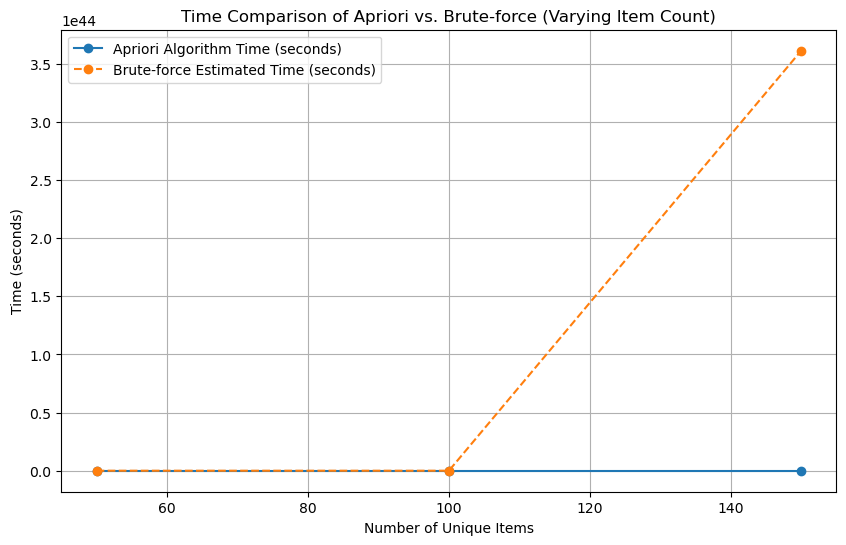

In [9]:
# 提取商品种类变化的数据集（E-G）
dataset_names_items = ["E", "F", "G"]
item_counts = [50, 100, 150]  # 对应E-G的数据集商品种类数
apriori_times_items = [results[name]["apriori_time"] for name in dataset_names_items]
brute_force_times_items = [results[name]["estimated_time"] for name in dataset_names_items]

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(item_counts, apriori_times_items, label="Apriori Algorithm Time (seconds)", marker='o')
plt.plot(item_counts, brute_force_times_items, label="Brute-force Estimated Time (seconds)", marker='o', linestyle='--')
plt.xlabel("Number of Unique Items")
plt.ylabel("Time (seconds)")
plt.title("Time Comparison of Apriori vs. Brute-force (Varying Item Count)")
plt.legend()
plt.grid()
plt.show()
